In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5001b2ae-386a-7dbe-9365-c88592db6f85)


# Import Data and Helper Functions

In [2]:
# Download Daniel Bourke's helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-18 05:44:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-18 05:44:13 (57.0 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook 
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
# Download the Natural Language Processing with Disaster Tweets dataset from Kaggle (here we use the one from ztm_tf_course which is the same as the one from kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2021-08-18 05:44:15--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.2’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-08-18 05:44:15 (146 MB/s) - ‘nlp_getting_started.zip.2’ saved [607343/607343]



In [5]:
# Unzip the data
unzip_data ('nlp_getting_started.zip')

In [6]:
# Turn the csv files into pandas dataframe
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


# Visualize the Data

In [7]:
# Shuffle the training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # frac is the fraction of dataframe to return and random_state value ensures reproducibility

In [8]:
train_df_shuffled.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


### We are going to write code to find the value of the target column based on the text column

### Inputs (text coumn) --> Machine Learning Algorithm --> Outputs (target column)

In [9]:
# The test data doesn't have a target column
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# Check how many examples of each target value we have
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Since we have 2 target values, we are gonna be doing binary classification

### Here, 1 is a real disaster Tweet and 0 is not a real disaster Tweet

In [11]:
# Total number of samples we have
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df)+len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [12]:
# Visualize random training examples
import random # random generates pseudo-random numbers
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher then the number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples(): # returns the values of row as a tuple and loops over it
  _, text, target = row # only get these two column values from each row
  print(f'Target: {target}', '(real disaster)' if target > 0 else '(not real disaster)')
  print(f"Text:\n{text}\n")
  print('---\n')


Target: 0 (not real disaster)
Text:
@GreenLacey GodsLove &amp; #thankU my sister for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami

---

Target: 0 (not real disaster)
Text:
It was finally demolished in the spring of 2013 and the property has sat vacant since. The justÛ_: saddlebrooke... http://t.co/Vcjcykq8b8

---

Target: 0 (not real disaster)
Text:
It's so freeing to name a new .doc 'NEWIDEA' and then get back to #writing w/out having derailed yourself thinking of a title. Or w/twitter.

---

Target: 0 (not real disaster)
Text:
I found a diamond in the rubble

---

Target: 1 (real disaster)
Text:
Crazy storm hit and I'm trapped inside a Hobby Lobby AMA http://t.co/8qc8Bcxoko

---



# Split the data into trainig and validation sets

In [13]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), # converts the dataframe to numpy array
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1, # dedicates 10% of the samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [14]:
# Check the lengths of the sets
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [15]:
# View first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

# Converting Text Data to Numbers (Tokenization and Embeddings)


In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Initializing the text vectorizer
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (all of the different words in your text)
                                    standardize = 'lower_and_strip_punctuation',# how to process text
                                    split = 'whitespace', # how to split the tokens
                                    ngrams = None, # create groups of n words
                                    output_mode = 'int', # how to map tokens to numbers
                                    output_sequence_length=None, # how long should the output sequence of tokens be
                                    pad_to_max_tokens=True
                                    )

### We set the max_tokens to 10,000 and we find the output_sequence_length which will be the average number of tokens per tweet in the training dataset

In [17]:
# Find the average number of tokens (words) in the training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_Length = 10000 # max number of words in our dataset
max_length = 15 # max length of our sequences will be (how many words per tweet does our model see)
text_vectorizer = TextVectorization(max_tokens=max_vocab_Length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the trainig text
text_vectorizer.adapt(train_sentences) # adapt() maps text_vectorizer to out data

In [20]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

### What we have done is word level tokenization. Notice the 0's at the end of the returned tensor, this is because we set output_sequence_length=15, meaning no matter the size of the sequence we pass to text_vectorizer, it always returns a sequence with a length of 15.

In [21]:
# Chose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original Text:
RT @AmznFavorites THE DEVEREAUX DISASTER. 'Exciting scifi #thriller...' http://t.co/Mw9amBgAfq #SciFi #Kindle      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  96,    1,    2,    1,   75, 5694, 3439, 2259,    1, 3439, 1827,
           0,    0,    0,    0]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # gets all the unique words in the vocabulary
top_5_words = words_in_vocab[:5] # most common tokens (UNK token means "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")


Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Create an Embedding using Embedding Layer

In [23]:
from tensorflow.keras import layers
# Initialize the Embedding layer
embedding = layers.Embedding(input_dim=max_vocab_Length, # set the input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, initialize randomly
                             input_length=max_length)

In [24]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n {random_sentence}\
\n\nEmbedded Version:")

# Embed the random sentence (turn it into numerical representaion)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Text:
 5/6 will destroy Reg C competitiveness.   The entire region will B over-saturated.   Yes Brockton gets $12M and RegC Commonwealth PPC and

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00360912,  0.04432975,  0.00230187, ..., -0.02465419,
          0.02451265, -0.03434109],
        [-0.04320616,  0.01726519, -0.01462676, ...,  0.047023  ,
          0.04709803, -0.00514233],
        [-0.03551704, -0.01103346, -0.03134266, ...,  0.03498955,
         -0.00519005,  0.04889769],
        ...,
        [ 0.00375974,  0.00817446, -0.04364332, ...,  0.03330666,
          0.03759719, -0.0204911 ],
        [ 0.02002515,  0.00983226, -0.01081201, ...,  0.02367267,
         -0.01422318, -0.03963244],
        [ 0.00169345,  0.02608505,  0.01718011, ...,  0.03149169,
          0.01276172, -0.03408507]]], dtype=float32)>

### Each token in the sentence gets turned into a length 128 feature vector. Each sentence has 15 tokens. That's why the shape is 1, 15, 128

In [25]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 3.6091208e-03,  4.4329751e-02,  2.3018718e-03, -1.1275839e-02,
       -1.0211457e-02,  5.8976635e-03,  3.2003488e-02,  7.2542429e-03,
        4.0869262e-02, -3.4501888e-02, -4.5203995e-02,  4.0542517e-02,
        3.4782115e-02, -4.5295563e-02,  3.5314355e-02, -3.1369973e-02,
        2.1963958e-02, -2.2265971e-02, -2.3108236e-03, -1.6997010e-04,
        1.8542659e-02, -4.8918772e-02,  4.1039418e-02,  4.2511821e-03,
        1.8932570e-02, -3.6871135e-02,  1.3811477e-03,  1.5152384e-02,
        3.6678527e-02,  6.6074505e-03,  6.0535967e-05,  2.8665174e-02,
       -1.5963208e-02, -3.4892499e-02, -8.4078684e-03,  3.1673972e-02,
       -4.3817844e-02, -1.5275799e-02, -2.0707512e-02,  2.3119774e-02,
       -5.3257942e-03,  2.8534267e-02,  1.0083772e-02,  4.6621609e-02,
       -2.1574557e-02,  1.1500977e-02,  1.5444923e-02, -3.9726306e-02,
       -3.9109088e-02, -4.4067468e-02, -4.9886048e-02,  3.1835560e-02,
        3.3748735e-02,  3.580

# Create Models

### Steps to go through:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

## Model 0: Naive Bayes

### To create out baseline model to get a benchmark for future experiments to build upon, er create a scikit-learn pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinominal Naive Bayes algorithm. 

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Evaluate the model to find the baseline metrics

In [27]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function for our model experiments

Takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

In [29]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 1: Simple Dense Model

In [31]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save tensorboard logs
SAVE_DIR = 'model_logs'

In [32]:
# Build the model with the functional API

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1 dimensional strings
x = text_vectorizer(inputs) # turns input texts into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embeddings
outputs = layers.Dense(1, activation="sigmoid")(x) # create output layer, we want binary outputs so we use sigmoid activation (for categorical use softmax)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # constructs the model

In [33]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
# Get summary of model_1
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


### We created an embedding of soze 128 for a vocabulary of 10,000. So 128 x 10,000 = 1280000 parameters

In [35]:
# Fit the model to training data for 5 epochs
model_1.history = model_1.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                       experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20210818-054423
Epoch 1/5
215/215 [==============================] - 5s 7ms/step - loss: 0.6104 - accuracy: 0.6993 - val_loss: 0.5387 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4429 - accuracy: 0.8158 - val_loss: 0.4679 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3475 - accuracy: 0.8593 - val_loss: 0.4589 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2841 - accuracy: 0.8926 - val_loss: 0.4636 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2378 - accuracy: 0.9118 - val_loss: 0.4791 - val_accuracy: 0.7887


In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4791 - accuracy: 0.7887


[0.47907575964927673, 0.7887139320373535]

In [37]:
# Make predictions (these comeback in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.29977   ],
       [0.7241453 ],
       [0.9979164 ],
       [0.11123318],
       [0.12252843],
       [0.9316711 ],
       [0.9086821 ],
       [0.9923828 ],
       [0.96130884],
       [0.26767737]], dtype=float32)

### Since we used a sigmoid function, our predictions come back in the form of probabilities. To convert predictions to classes, we round them with a threshold value of 0.5

In [38]:
# Turn prediction probabilities into single dimensional tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [39]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)

In [40]:
model_1_results

{'accuracy': 78.87139107611549,
 'f1': 0.7852145092095362,
 'precision': 0.7953441303708004,
 'recall': 0.7887139107611548}

In [41]:
# Is our simple Keras model better than our baseline model
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## We creat a new function to compare any model to our baseline model

In [42]:
# Create a helper function to compare our baseline results to our new models
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.87, Difference: -0.39
Baseline precision: 0.81, New precision: 0.80, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.00
Baseline f1: 0.79, New f1: 0.79, Difference: -0.00


### Our first model (model_1) contained an embedding layer which learned a way of representing words as feature vectors by passing over the training data

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

### Let's take a look at the embedding layer's weights (these are numerical representations of each word)

In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Get the weight matrix of the embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding size vector)

(10000, 128)


## Recurrent Neural Networks

## Model 2:LSTM (Long short term memory)

In [46]:
# Create our LSTM Model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [47]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210818-054435
Epoch 1/5
215/215 [==============================] - 8s 12ms/step - loss: 0.2111 - accuracy: 0.9272 - val_loss: 0.5785 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1570 - accuracy: 0.9423 - val_loss: 0.6428 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1285 - accuracy: 0.9514 - val_loss: 0.6514 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1028 - accuracy: 0.9597 - val_loss: 0.8756 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0840 - accuracy: 0.9657 - val_loss: 1.1347 - val_accuracy: 0.7730


In [50]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[1.5951982e-03],
        [8.0798143e-01],
        [9.9981695e-01],
        [1.3878454e-02],
        [2.6173526e-04],
        [9.9906045e-01],
        [9.5776582e-01],
        [9.9987423e-01],
        [9.9977547e-01],
        [6.9741303e-01]], dtype=float32))

In [51]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [52]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7710949612836401,
 'precision': 0.7742755789705,
 'recall': 0.7729658792650919}

In [53]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 77.30, Difference: -1.97
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Model 3:GRU (Gated Recurrent Unit)

In [54]:
# Build an RNN model using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x=layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="Model_3_GRU")

In [55]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# Get summary of the model
model_3.summary()

Model: "Model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


### LSTM cells have more trainable parameters than GRU cells

In [57]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU" )])

Saving TensorBoard log files to: model_logs/GRU/20210818-054458
Epoch 1/5
215/215 [==============================] - 4s 10ms/step - loss: 0.1552 - accuracy: 0.9409 - val_loss: 0.8067 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0813 - accuracy: 0.9693 - val_loss: 0.9969 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0680 - accuracy: 0.9733 - val_loss: 0.9393 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0575 - accuracy: 0.9746 - val_loss: 1.1687 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0508 - accuracy: 0.9784 - val_loss: 1.1899 - val_accuracy: 0.7795


In [58]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[6.5848965e-04],
        [7.7392125e-01],
        [9.9985337e-01],
        [6.2067371e-02],
        [1.3768836e-04],
        [9.9972278e-01],
        [8.6527115e-01],
        [9.9993181e-01],
        [9.9989402e-01],
        [8.7438649e-01]], dtype=float32))

In [59]:
# Convert the prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [60]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 77.95275590551181,
 'f1': 0.7776506830100394,
 'precision': 0.7811151206076258,
 'recall': 0.7795275590551181}

In [61]:
# Comapare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Model 4:Bidirectional RNN model

In [62]:
# Build bidirectional RNN with tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional_RNN")

In [63]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
# Get model summary
model_4.summary()

Model: "model_4_Bidirectional_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,
                                               val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/Bidirectional_RNN/20210818-054508
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.1028 - accuracy: 0.9701 - val_loss: 0.9617 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0526 - accuracy: 0.9772 - val_loss: 1.1399 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0442 - accuracy: 0.9794 - val_loss: 1.4102 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0496 - accuracy: 0.9794 - val_loss: 1.0429 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0451 - accuracy: 0.9793 - val_loss: 1.2878 - val_accuracy: 0.7703


In [66]:
# Make predictions with bidirectional RNN on validation data
model_4_pred_probs = model_4.predict(val_sentences)

In [67]:
model_4_pred_probs[:10]

array([[1.1863598e-02],
       [8.3610344e-01],
       [9.9985409e-01],
       [2.6843926e-01],
       [1.0610354e-05],
       [9.9912828e-01],
       [8.3284414e-01],
       [9.9997044e-01],
       [9.9992275e-01],
       [7.0323658e-01]], dtype=float32)

In [68]:
# Convert the prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [69]:
# Calculate bidirectional RNN results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'f1': 0.7683227325217538,
 'precision': 0.7718252603398367,
 'recall': 0.7703412073490814}

In [70]:
# Check performance against baseline model
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Using CNNs for Text

## Model 5:Conv1D (Temporal Convolution)

In [71]:
# Test out the embedding, 1D convolution and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalAveragePooling1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [72]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.0380373 ,  0.03715516, -0.01305072, ...,  0.01131982,
           0.00947844, -0.0318321 ],
         [-0.07146953, -0.00405229,  0.00722739, ..., -0.00029891,
          -0.05608712, -0.05828224],
         [-0.02481517,  0.03885648,  0.01064512, ...,  0.06255261,
          -0.01695915, -0.03550133],
         ...,
         [ 0.01567172,  0.00294966,  0.02651889, ...,  0.03134949,
           0.02203247, -0.02747479],
         [ 0.01567172,  0.00294966,  0.02651889, ...,  0.03134949,
           0.02203247, -0.02747479],
         [ 0.01567172,  0.00294966,  0.02651889, ...,  0.03134949,
           0.02203247, -0.02747479]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.03416327, 0.        , 0.07907262, 0.        ,
          0.10150522, 0.00970192, 0.04804736, 0.        , 0.        ,
          0.02350046, 0.04065965, 0.        , 0.02061619, 0.07634187,
          0.07246906, 0.

In [73]:
# Create 1D convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary of the model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [74]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210818-054545
Epoch 1/5
215/215 [==============================] - 4s 9ms/step - loss: 0.1378 - accuracy: 0.9553 - val_loss: 0.8353 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0755 - accuracy: 0.9721 - val_loss: 1.0018 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0610 - accuracy: 0.9765 - val_loss: 1.0895 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0552 - accuracy: 0.9778 - val_loss: 1.1728 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0505 - accuracy: 0.9787 - val_loss: 1.1974 - val_accuracy: 0.7585


In [75]:
# Make predictions with model 5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[2.5452504e-01],
       [7.7987003e-01],
       [9.9993563e-01],
       [1.0218226e-01],
       [4.6757950e-07],
       [9.9907386e-01],
       [9.9475938e-01],
       [9.9994576e-01],
       [9.9999964e-01],
       [7.7219975e-01]], dtype=float32)

In [76]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)

model_5_results

{'accuracy': 75.8530183727034,
 'f1': 0.7573131746360092,
 'precision': 0.7584850115306213,
 'recall': 0.7585301837270341}

In [78]:
# Compare model 5 to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 75.85, Difference: -3.41
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Model 6:Tensorsflow hub pretrained sentence encoder (encoder-decoder model)


In [79]:
# Example of pretrained embedding with universal sentence encoder
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load universal sentence encoder
embed_samples = embed([sample_sentence, "when you call universal sentence encoder on a sentence, it turns it into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [80]:
# Each sentence has been encoded to a 512 dimension vector
embed_samples.shape

TensorShape([2, 512])

In [81]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (Feature Extraction)
                                        name="USE")

In [82]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer, # take in sentences and then encode them into an embedding
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1, activation="sigmoid")], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary of the model
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [83]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210818-054615
Epoch 1/5
215/215 [==============================] - 8s 25ms/step - loss: 0.5043 - accuracy: 0.7886 - val_loss: 0.4572 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4153 - accuracy: 0.8140 - val_loss: 0.4386 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4017 - accuracy: 0.8229 - val_loss: 0.4343 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3939 - accuracy: 0.8256 - val_loss: 0.4293 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3862 - accuracy: 0.8273 - val_loss: 0.4282 - val_accuracy: 0.8189


In [84]:
# Make predictions on the model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.17686911],
       [0.7771318 ],
       [0.9886696 ],
       [0.20796344],
       [0.7469005 ],
       [0.7143102 ],
       [0.9810847 ],
       [0.97433144],
       [0.94391453],
       [0.13107583]], dtype=float32)

In [85]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [86]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'f1': 0.817984880977007,
 'precision': 0.8196605460013572,
 'recall': 0.8188976377952756}

In [87]:
# Compare to baseline model
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.89, Difference: 2.62
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


## Model 7: Tensorflow Hub pretrained sentence encoder on 10% of training data

In [88]:
# Split the training data into 90/10 ratios
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42
                                                                                                                            )

In [89]:
# Check the length of targets in out subset of data
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [90]:
# Clone model 6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [91]:
# Fit the model on 10% training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence encoder/20210818-054637
Epoch 1/5
22/22 [==============================] - 4s 120ms/step - loss: 0.6702 - accuracy: 0.7085 - val_loss: 0.6492 - val_accuracy: 0.7100
Epoch 2/5
22/22 [==============================] - 1s 24ms/step - loss: 0.6013 - accuracy: 0.7915 - val_loss: 0.5958 - val_accuracy: 0.7388
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5235 - accuracy: 0.8163 - val_loss: 0.5401 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4597 - accuracy: 0.8324 - val_loss: 0.5089 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4147 - accuracy: 0.8367 - val_loss: 0.4911 - val_accuracy: 0.7822


In [92]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.25069603],
       [0.8008594 ],
       [0.88694865],
       [0.329461  ],
       [0.5166626 ],
       [0.8128514 ],
       [0.8160469 ],
       [0.8573748 ],
       [0.83087504],
       [0.10663972]], dtype=float32)

In [93]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.21522309711287,
 'f1': 0.779088324447517,
 'precision': 0.7868451603977311,
 'recall': 0.7821522309711286}

In [95]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 78.22, Difference: -1.05
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# Comparing the performance of each of our models

In [96]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame ({"baseline": baseline_results,
                                   "simple_dense": model_1_results,
                                   "lstm": model_2_results,
                                   "gru" : model_3_results,
                                   "bidirectional": model_4_results,
                                   "conv1d": model_5_results,
                                   "tf_hub_sentence_encoder": model_6_results,
                                   "tf_hub_10_percent_data": model_7_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.871391,0.795344,0.788714,0.785215
lstm,77.296588,0.774276,0.772966,0.771095
gru,77.952756,0.781115,0.779528,0.777651
bidirectional,77.034121,0.771825,0.770341,0.768323
conv1d,75.853018,0.758485,0.758530,0.757313
tf_hub_sentence_encoder,81.889764,0.819661,0.818898,0.817985
tf_hub_10_percent_data,78.215223,0.786845,0.782152,0.779088


In [97]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

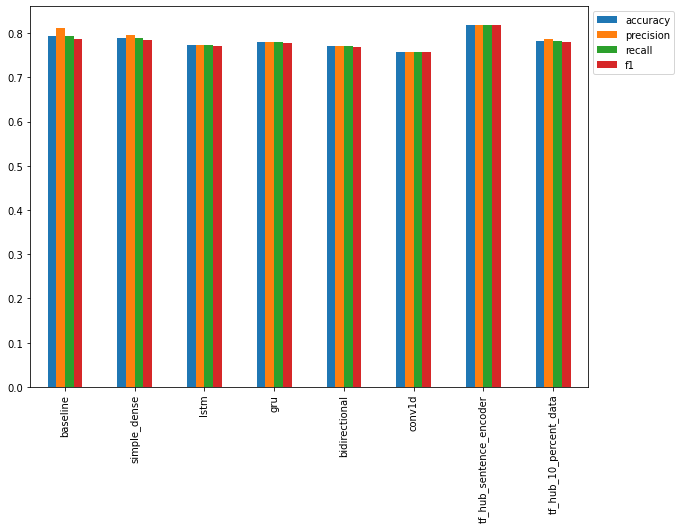

In [98]:
# Plot and compare all of the models
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

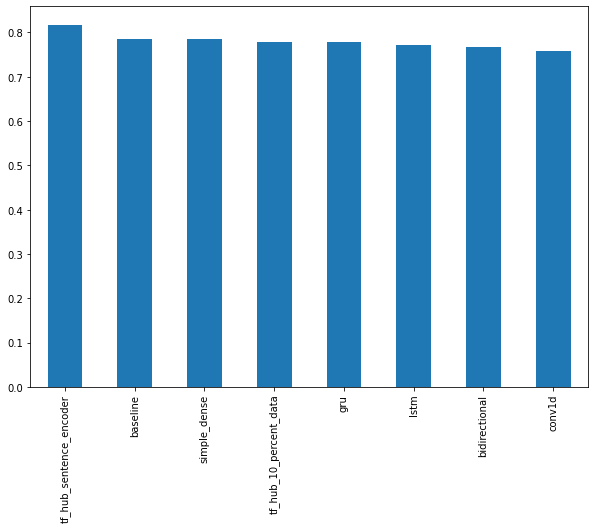

In [99]:
# Sort model results by f1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

# Combining our Models

Many production systems use an ensemble (multiple different models combined) of models to make a prediction. The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by singular model. Uncorrelated means different kinds of models like models that use different algorithms. There are a few ways we can combine our models:
* Averaging - Take the output prediction probabilities of each model for each sample, combine them and average them.
* Majority Vote - Make class predictions with each of your models on all samples, the predicted class is the one in majority.
* Model Stacking - Take the outputs of each of your chosen models and use them as inputs to another model

In [100]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 1.], dtype=float32)>

In [101]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 77.29658792650919,
 'f1': 0.7725599551282146,
 'precision': 0.7726074857232031,
 'recall': 0.7729658792650919}

In [102]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [103]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [104]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.788714,0.795344,0.788714,0.785215
lstm,0.772966,0.774276,0.772966,0.771095
gru,0.779528,0.781115,0.779528,0.777651
bidirectional,0.770341,0.771825,0.770341,0.768323
conv1d,0.758530,0.758485,0.758530,0.757313
tf_hub_sentence_encoder,0.818898,0.819661,0.818898,0.817985
tf_hub_10_percent_data,0.782152,0.786845,0.782152,0.779088
ensemble_results,0.772966,0.772607,0.772966,0.772560


# Saving and Loading a trained model

In [105]:
# Save TF Hub Sentence Encoder model to HD5 format
model_6.save("model_6.h5")

In [106]:
# Load model with custom Hub Layer (required with HDF5 formay)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [107]:
# How does our loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4282 - accuracy: 0.8189


[0.4282020330429077, 0.8188976645469666]

In [108]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [109]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [110]:
# Evaluate loaded savedmodel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4282 - accuracy: 0.8189


[0.4282020330429077, 0.8188976645469666]

# Finding the most wrong examples in our data

In [111]:
# Create dataframe with validation sentences and best perfomring model preditctions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})

val_df.head(10)

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.176869
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.777132
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988670
3,@camilacabello97 Internally and externally scr...,1,0.0,0.207963
4,Radiation emergency #preparedness starts with ...,1,1.0,0.746900
5,Investigators rule catastrophic structural fai...,1,1.0,0.714310
6,How the West was burned: Thousands of wildfire...,1,1.0,0.981085
7,Map: Typhoon Soudelor's predicted path as it a...,1,1.0,0.974331
8,Ûª93 blasts accused Yeda Yakub dies in Karach...,1,1.0,0.943915
9,My ears are bleeding https://t.co/k5KnNwugwT,0,0.0,0.131076


In [112]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.930531
759,FedEx will no longer transport bioterror patho...,0,1.0,0.882908
628,@noah_anyname That's where the concentration c...,0,1.0,0.877593
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.858503
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.844712
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.839270
144,The Sound of Arson,0,1.0,0.831637
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.817798
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.807168
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.802785


In [113]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9305312633514404
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8829075694084167
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8775930404663086
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8585025072097778
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8447118401527405
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1, Prob: 0.839269757270813
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Pr

In [114]:
# Check the most wrong false negatives (model predicted 0 when should've predicted 1)
for row in most_wrong[-10:].itertuples(): # the last rows in the dataframe contain the false negatives
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.07492450624704361
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.07192434370517731
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.07190728932619095
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.07145275920629501
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05689367279410362
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.05533766373991966
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05437540635